In [12]:
#import package
import numpy as np
import pandas as pd
import nltk
import re
import pickle
import networkx as nx
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize
import random

In [13]:
#load dataset
df=pickle.load(open('df_filtered.pkl','rb'))

# Data Cleaning and Processing

In [14]:
sentences = []
for s in df['text']:
    #split into sentences
    token=sent_tokenize(s)
    #lowercase
    token=[x.lower() for x in token]
    #remove punctuation
    token=[re.sub("[^a-zA-Z]+", " ", x) for x in token]
    #remove stop words
    stop_list = set(stopwords.words('english')) 
    filtered_tokens=[word for word in token if word not in stop_list]
    sentences.append(filtered_tokens)
#df['sentences']=sentences

# Embedding

In [15]:
# Extract word vectors using pre-trained GLOVE model
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [16]:
whole_sentence_vectors=[]
for x in sentences:
    sentence_vectors = []
    for i in x:
        if len(i) != 0:
            v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i])/(len(i.split())+0.001)
        else:
            v = np.zeros((100,))
        sentence_vectors.append(v)
    whole_sentence_vectors.append(sentence_vectors)

In [72]:
df['sentences_vector']=whole_sentence_vectors

# Similarity Matrix

In [27]:
# similarity matrix
all_rank=[]
G=[]
for y in range(len(sentences)):
    num_sen=len(sentences[y])
    sim_mat = np.zeros([num_sen, num_sen])
    for i in range(num_sen):
        for j in range(num_sen):
            if i != j:
                sim_mat[i][j] = cosine_similarity(whole_sentence_vectors[y][i].reshape(1,100), whole_sentence_vectors[y][j].reshape(1,100))[0,0]
    nx_graph = nx.from_numpy_array(sim_mat)
    G.append(nx_graph)
    scores = nx.pagerank(nx_graph)
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences[y])), reverse=True)
    all_rank.append(ranked_sentences)


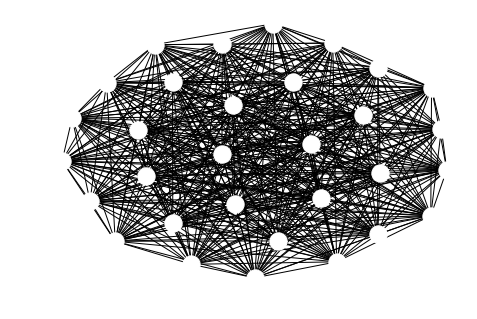

In [34]:
from matplotlib import pyplot as plt
nx.draw(G[1],cmap = plt.get_cmap('jet'),node_color = 'white')
plt.show()

In [74]:
df['all_rank_result']=all_rank

# Get Summary

In [130]:
df['len']=[len(x) for x in df.sentences]
df_2=df[df['len']!=1]
df_3=df_2[df.len!=0]

In [142]:
df_2.sentences[1224][1]

'that means it has wet tail which could possibly be contagious if the hamster stands up on it s hind legs don t buy it because that means its getting ready to attack they are just getting used to being held ask the pet shop breeder which ones are the friendliest '

In [159]:
#random
import random
random_s_all=[]
for x in df_3.sentences:
    random_s=random.choice(x)
    random_s_all.append(random_s)


In [160]:
#lead
lead_s_all=[]
for x in df_3.sentences:
    lead_s=x[0]
    lead_s_all.append(lead_s)

In [163]:
#text rank based
primary_s_all=[]
two_s=[]
for x in df_3.all_rank_result:
    primary_s=0
    secondary_s=0
    primary_s=x[0][1]
    secondary_s=x[1][1]
    two=primary_s+'.'+secondary_s
    primary_s_all.append(primary_s)
    two_s.append(two)


In [165]:
df_3['rank_summary']=primary_s_all
df_3['rank_summary_2']=two_s
df_3['random_summary']=random_s_all
df_3['lead_summary']=lead_s_all

/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Azzurro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [183]:
df_3.to_csv('extractive_summary.csv')